In [19]:
import sys
sys.path.append('../src')

import warnings
warnings.filterwarnings("ignore")

import logging
from bunch import Bunch

import torch
from torch.utils.data import DataLoader, Subset
from torch.nn import BCELoss
from torch.optim import Adam
from sklearn.metrics import roc_auc_score


from pytorch_common.modules.fn import Fn
from pytorch_common.kfoldcv import StratifiedKFoldCV, ParallelKFoldCVStrategy
from pytorch_common.callbacks import EarlyStop, ReduceLROnPlateau, Validation
from pytorch_common.callbacks.output import Logger, MetricsPlotter
from pytorch_common.util import train_val_split, \
                                set_device_name, \
                                set_device_memory, \
                                get_device, \
                                LoggerBuilder
from modules import DeepFM

from dataset.movielens import MovieLens1MDataset, \
                              MovieLens20MDataset

In [12]:
LoggerBuilder().on_console().build()
set_device_name('gpu')
device = get_device()

In [13]:
def load_dataset(name):
    if '1m' == name:
        dataset_path = '../datasets/ml-1m/ratings.dat'
        dataset = MovieLens1MDataset(dataset_path=dataset_path)
    else:
        dataset_path = '../datasets/ml-20m/ratings.csv'
        dataset = MovieLens20MDataset(dataset_path=dataset_path)

    logging.info('{} dataset loaded! Shape: {}'.format(dataset_path, dataset.shape))
    logging.info('Target count: {}'.format(dataset.targets_count()))

    return dataset

In [14]:
dataset = load_dataset('1m')
train_subset, test_subset = train_val_split(dataset, train_percent=.7)

2022-02-28 11:57:33,110 - INFO - ../datasets/ml-1m/ratings.dat dataset loaded! Shape: (1000209, 2)
2022-02-28 11:57:33,126 - INFO - Target count: {0.0: 424928, 1.0: 575281}


In [15]:
def train_fn(train_subset, train_idx, val_idx, ps, fold):
    model = DeepFM(
        ps.features_n_values,
        ps.embedding_size,
        ps.units_per_layer,
        ps.dropout
    ).to(ps.device)
    
    train_set = DataLoader(Subset(train_subset, train_idx), ps.batch_size, num_workers=ps.num_workers)
    val_set   = DataLoader(Subset(train_subset, val_idx),   ps.batch_size, num_workers=ps.num_workers)

    result = model.fit(
        train_set,
        loss_fn     = BCELoss(),
        epochs      = ps.epochs,
        optimizer   = Adam(
            params       = model.parameters(),
            lr           = ps.lr,
            weight_decay = ps.weight_decay
        ),
        callbacks   = [
            Validation(
                val_set,
                metrics = {
                    'val_loss': lambda y_pred, y_true: BCELoss()(y_pred, y_true).item(),
                    'val_auc' : lambda y_pred, y_true: roc_auc_score(y_true.cpu().numpy(), y_pred.cpu().numpy())
                },
                each_n_epochs=1
            ),
            Logger(['fold', 'time', 'epoch', 'train_loss', 'val_loss', 'val_auc', 'patience', 'lr']),
            # MetricsPlotter(metrics=['train_loss', 'val_loss', 'val_auc']),
            ReduceLROnPlateau(metric='val_auc', mode='max', factor=ps.lr_factor, patience=ps.lr_patience),
            EarlyStop(metric='val_auc', mode='max', patience=3)
        ],
        extra_ctx = {'fold': fold+1}
    )

    return result.val_auc

In [20]:
cv = StratifiedKFoldCV(
    train_fn,
    get_y_values_fn = lambda ss: ss.dataset.targets[train_subset.indices],
    k_fold          = 10
)

params = Bunch({
    'seed': 42,
    'lr': 0.001,
    'lr_factor': 0.1,
    'lr_patience': 1,
    'weight_decay': 1e-6,
    'epochs': 50,
    'embedding_size': 50,
    'units_per_layer': [200, 200, 200],
    'dropout': 0.8,
    'batch_size': 4000,
    'num_workers': 12,
    'features_n_values': dataset.field_dims,
    'device': get_device()
})

cv.train(train_subset, params)

2022-02-28 11:58:19,165 - INFO - {'fold': 1, 'time': '0:00:02.63', 'epoch': 1, 'train_loss': 0.7296909339065794, 'val_loss': 0.8649330735206604, 'val_auc': 0.7657019631599431, 'patience': 0}
2022-02-28 11:58:21,412 - INFO - {'fold': 1, 'time': '0:00:02.23', 'epoch': 2, 'train_loss': 0.5983780886553511, 'val_loss': 0.8611738085746765, 'val_auc': 0.7789850804530203, 'patience': 0, 'lr': 0.001}
2022-02-28 11:58:23,578 - INFO - {'fold': 1, 'time': '0:00:02.15', 'epoch': 3, 'train_loss': 0.5790253492850291, 'val_loss': 0.8399388790130615, 'val_auc': 0.7820739657549188, 'patience': 0, 'lr': 0.001}
2022-02-28 11:58:25,957 - INFO - {'fold': 1, 'time': '0:00:02.37', 'epoch': 4, 'train_loss': 0.570525465132315, 'val_loss': 0.8111974596977234, 'val_auc': 0.7828105808518748, 'patience': 0, 'lr': 0.001}
2022-02-28 11:58:28,142 - INFO - {'fold': 1, 'time': '0:00:02.17', 'epoch': 5, 'train_loss': 0.564203685974773, 'val_loss': 0.7847101092338562, 'val_auc': 0.783969632695432, 'patience': 0, 'lr': 0.0

{'mean': 0.7978956317765783,
 'median': 0.798498006442081,
 'scores': [0.7930205160835444,
  0.7977654656535806,
  0.8014788710713956,
  0.7999685845025637,
  0.7983541679047594,
  0.7988799979191359,
  0.7938837008958687,
  0.797185907339724,
  0.7986418449794025,
  0.7997772614158082]}

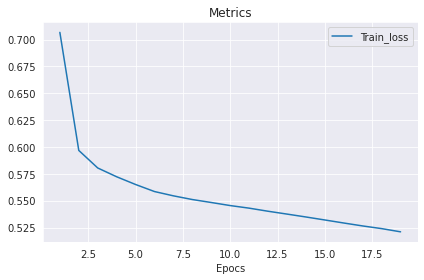

In [21]:
epochs = 20

model = DeepFM(
    params.features_n_values,
    params.embedding_size,
    params.units_per_layer,
    params.dropout
).to(params.device)

result = model.fit(
    data_loader = DataLoader(
        train_subset, 
        params.batch_size, 
        num_workers = params.num_workers * 2
    ),
    loss_fn     = BCELoss(),
    epochs      = epochs,
    optimizer   = Adam(
        params       = model.parameters(),
        lr           = params.lr,
        weight_decay = params.weight_decay
    ),
    callbacks   = [Logger(), MetricsPlotter()]
)

In [22]:
result.items()

dict_items([('verbose', 1), ('epochs', 20), ('optimizer', Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 1e-06
)), ('loss_fn', BCELoss()), ('device', device(type='cuda', index=0)), ('model', DeepFM(
  (lineal): CategoricalFeaturesLineal(
    (embedding): MultiFeatureEmbedding(
      (embedding): Embedding(9992, 1)
    )
  )
  (fm): EmbeddingFactorizationMachine()
  (embedding): MultiFeatureEmbedding(
    (embedding): Embedding(9992, 50)
  )
  (mlp): MultiLayerPerceptron(
    (mlp): Sequential(
      (0): Linear(in_features=100, out_features=200, bias=True)
      (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.8, inplace=False)
      (4): Linear(in_features=200, out_features=200, bias=True)
      (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.8, inplace=False)
   

In [23]:
test_data_loader = DataLoader(
    test_subset, 
    params.batch_size, 
    num_workers=params.num_workers * 2
)

Fn.validation_score(model, test_data_loader, get_device(), roc_auc_score)

0.7957088893021369